## Faster R-CNN(coco_pytorch)

- Faster RCNN : https://pytorch.org/vision/0.9/_modules/torchvision/models/detection/faster_rcnn.html#fasterrcnn_resnet50_fpn

- COCO API : https://github.com/cocodataset/cocoapi


### 데이터 다운로드

MS COCO 데이터셋은 약 328000장의 이미지와 80개의 클래스로 이루어져있으나, 워낙 대규모이기 때문에 개와 고양이 클래스를 소규모로 샘플링해 실습을 진행합니다.



In [ ]:
!pip install kaggle --upgrade

In [ ]:
import kagglehub
import os


# Download latest version
path = kagglehub.dataset_download("s076923/pytorch-transformer")
print("Path to dataset files:", path)

100%|██████████| 916M/916M [00:06<00:00, 152MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/s076923/pytorch-transformer/versions/4


In [ ]:
# 먼저, 압축 파일(pytorch-transformer.zip)을 지정된 경로(현재 디렉토리)로 압축 해제합니다.
import shutil

shutil.move(path, './')


'./4'

In [ ]:
# 작업 디렉토리를 변경합니다.
import os
os.chdir("/content/4/datasets/")  # 작업할 데이터셋 폴더로 이동 (실행 환경에 따라 경로가 달라질 수 있음)

### 데이터셋

COCO 데이터는 "ID"를 기준으로 파싱을 해야 합니다.    
images:

- 각 이미지에 대한 정보가 담긴 리스트
- 각 항목은 이미지의 고유 id, 파일명, 너비, 높이 등의 정보를 포함합니다.

annotations:

- 각 이미지에 대한 어노테이션 정보(예: 바운딩 박스, 라벨)를 담은 리스트

categories:

- 객체의 카테고리 정보를 담은 리스트


```
{
	"info": {
		"year": 2021,
		"version": "1.0",
		"description": "For object detection",
		"date_created": "2021"
	},
	"images": [
		{
			"date_captured": "2021",
			"file_name": "000000000001.jpg",
			"id": 1,
			"height": 480,
			"width": 640
		},
		{
			"date_captured": "2021",
			"file_name": "000000000002.jpg",
			"id": 2,
			"height": 426,
			"width": 640
		},
		{
			"date_captured": "2021",
			"file_name": "000000000003.jpg",
			"id": 3,
			"height": 428,
			"width": 640
		},
		{
			"date_captured": "2021",
			"file_name": "000000000004.jpg",
			"id": 4,
			"height": 425,
			"width": 640
		},
		{
			"date_captured": "2021",
			"file_name": "000000000005.jpg",
			"id": 5,
			"height": 640,
			"width": 481
		}
	],
	"licenses": [
		{
			"id": 1,
			"name": "GNU General Public License v3.0",
			"url": "https://github.com/zhiqwang/yolov5-rt-stack/blob/master/LICENSE"
		}
	],
	"type": "instances",
	"annotations": [
		{
			"segmentation": [
				[
					1.0799999999999272,
					187.69008000000002,
					612.66976,
					187.69008000000002,
					612.66976,
					473.53008000000005,
					1.0799999999999272,
					473.53008000000005
				]
			],
			"area": 174816.81699840003,
			"iscrowd": 0,
			"image_id": 1,
			"bbox": [
				1.0799999999999272,
				187.69008000000002,
				611.5897600000001,
				285.84000000000003
			],
			"category_id": 19,
			"id": 1
		},
		{
			"segmentation": [
				[
					311.73024,
					4.310159999999996,
					631.0102400000001,
					4.310159999999996,
					631.0102400000001,
					232.99032,
					311.73024,
					232.99032
				]
			],
			"area": 73013.00148480001,
			"iscrowd": 0,
			"image_id": 1,
			"bbox": [
				311.73024,
				4.310159999999996,
				319.28000000000003,
				228.68016
			],
			"category_id": 50,
			"id": 2
		},
        ],
"categories": [
		{
			"id": 1,
			"name": "0",
			"supercategory": "0"
		},
		{
			"id": 2,
			"name": "1",
			"supercategory": "1"
		},
		{
			"id": 3,
			"name": "2",
			"supercategory": "2"
		},
        ]
}
```

In [ ]:
import os              # 파일 및 디렉토리 경로를 다루기 위한 표준 라이브러리
import json            # JSON 파일을 읽고 쓰기 위한 표준 라이브러리
import torch           # 딥러닝 라이브러리 PyTorch (텐서 연산 등)
from PIL import Image  # 이미지를 다루기 위한 Pillow 라이브러리
from torch.utils.data import Dataset  # PyTorch의 Dataset 클래스를 상속받기 위한 모듈

# COCO 데이터셋의 JSON 파일을 직접 파싱하기 위한 사용자 정의 클래스
class CustomCOCO:
    def __init__(self, annotation_file):
        """
        CustomCOCO 클래스 초기화 함수.
        :param annotation_file: COCO 데이터셋의 어노테이션(JSON) 파일 경로
        """
        # JSON 파일을 열어서 데이터를 읽습니다.
        with open(annotation_file, 'r') as f:
            self.data = json.load(f)

        # 이미지 정보를 'id'를 키로 하는 딕셔너리로 저장합니다.
        # 각 이미지 정보는 JSON 파일의 "images" 리스트에 저장되어 있습니다.
        self.images = {img["id"]: img for img in self.data.get("images", [])}

        # 어노테이션(annotation) 정보를 이미지 id별로 그룹화합니다.
        # JSON 파일의 "annotations" 리스트를 순회하며, 각 어노테이션을 해당 이미지 id 아래에 저장합니다.
        self.annotations = {}
        for ann in self.data.get("annotations", []):
            img_id = ann["image_id"]
            if img_id not in self.annotations:
                self.annotations[img_id] = []
            self.annotations[img_id].append(ann)

        # 카테고리 정보를 'id'를 키로 하는 딕셔너리로 저장합니다.
        # JSON 파일의 "categories" 리스트에 각 카테고리 정보가 저장되어 있습니다.
        self.cats = {cat["id"]: cat for cat in self.data.get("categories", [])}

    def loadImgs(self, ids):
        """
        주어진 이미지 id 리스트에 해당하는 이미지 정보(딕셔너리)를 반환합니다.
        :param ids: 이미지 id의 리스트
        :return: 해당 id의 이미지 정보 리스트
        """
        return [self.images[i] for i in ids if i in self.images]

    def getAnnIds(self, imgIds):
        """
        주어진 이미지 id들에 대해, 어노테이션 id들을 모두 모아 리스트로 반환합니다.
        :param imgIds: 이미지 id의 리스트
        :return: 어노테이션 id들의 리스트
        """
        ann_ids = []
        for img_id in imgIds:
            if img_id in self.annotations:
                ann_ids.extend([ann["id"] for ann in self.annotations[img_id]])
        return ann_ids

    def loadAnns(self, annIds):
        """
        주어진 어노테이션 id 리스트에 해당하는 어노테이션 정보를 반환합니다.
        :param annIds: 어노테이션 id의 리스트
        :return: 해당 어노테이션 정보 리스트
        """
        anns = []
        # 모든 어노테이션을 순회하면서 id가 annIds에 포함된 것만 선택합니다.
        for ann in self.data.get("annotations", []):
            if ann["id"] in annIds:
                anns.append(ann)
        return anns

# PyTorch Dataset 클래스를 상속받아 COCO 데이터셋을 처리하기 위한 클래스
class COCODataset(Dataset):
    def __init__(self, root, train, transform=None):
        """
        COCODataset 클래스 초기화 함수.
        :param root: 데이터셋의 최상위 디렉토리 경로
        :param train: 학습용 데이터(True)와 검증용 데이터(False)를 구분
        :param transform: 이미지에 적용할 전처리 함수 (예: tensor 변환)
        """
        super().__init__()
        # 학습 데이터면 'train' 폴더, 검증 데이터면 'val' 폴더를 사용합니다.
        directory = "train" if train else "val"
        # 어노테이션 파일의 경로를 생성합니다.
        annotations_file = os.path.join(root, "annotations", f"{directory}_annotations.json")

        # pycocotools 대신 사용자 정의 CustomCOCO 클래스를 사용하여 어노테이션 데이터를 로드합니다.
        self.coco = CustomCOCO(annotations_file)
        # 이미지 파일들이 저장된 폴더 경로를 지정합니다.
        self.image_path = os.path.join(root, directory)
        # 이미지 전처리(transform) 함수 저장 (필요할 경우 사용)
        self.transform = transform

        # COCO 데이터셋의 카테고리 정보를 저장합니다.
        # 0번은 배경("background")으로 초기화합니다.
        self.categories = {0: "background"}
        for cat_id, cat in self.coco.cats.items():
            self.categories[cat_id] = cat["name"]

        # 이미지와 어노테이션 정보를 로드하여 data 리스트에 저장합니다.
        self.data = self._load_data()

    def _load_data(self):
        """
        COCO 데이터셋의 각 이미지에 대해 이미지와 해당 어노테이션 정보를 로드합니다.
        :return: (이미지, target) 튜플들의 리스트
        """
        data = []
        # self.coco.images는 이미지 id를 키로 가지는 딕셔너리입니다.
        for _id, img_info in self.coco.images.items():
            # 이미지 파일 이름 추출
            file_name = img_info["file_name"]
            # 이미지 파일의 전체 경로 생성
            image_path = os.path.join(self.image_path, file_name)
            # PIL을 사용해 이미지를 RGB 모드로 불러옵니다.
            image = Image.open(image_path).convert("RGB")

            boxes = []   # 바운딩 박스 좌표를 저장할 리스트
            labels = []  # 바운딩 박스에 해당하는 카테고리 id를 저장할 리스트
            # 해당 이미지에 대한 어노테이션 정보를 가져옵니다.
            anns = self.coco.annotations.get(_id, [])
            for ann in anns:
                # 어노테이션에서 [x, y, width, height] 정보를 가져옴
                x, y, w, h = ann["bbox"]
                # 바운딩 박스 좌표를 [x_min, y_min, x_max, y_max] 형태로 변환
                boxes.append([x, y, x + w, y + h])
                # 카테고리 id 저장
                labels.append(ann["category_id"])

            # target 딕셔너리에 이미지 id, 바운딩 박스, 라벨 정보를 텐서(tensor) 형태로 저장합니다.
            target = {
                "image_id": torch.LongTensor([_id]),
                "boxes": torch.FloatTensor(boxes),
                "labels": torch.LongTensor(labels)
            }
            # 이미지와 target 정보를 튜플 형태로 data 리스트에 추가합니다.
            data.append((image, target))
        return data

    def __getitem__(self, index):
        """
        Dataset의 특정 index에 해당하는 (이미지, target) 튜플을 반환합니다.
        :param index: 데이터셋 내 샘플의 인덱스
        :return: (이미지, target) 튜플
        """
        image, target = self.data[index]
        # 만약 전처리 함수(transform)가 지정되어 있다면 이미지에 적용합니다.
        if self.transform:
            image = self.transform(image)
        return image, target

    def __len__(self):
        """
        데이터셋에 포함된 전체 샘플 개수를 반환합니다.
        :return: 샘플 개수
        """
        return len(self.data)


In [ ]:
# torchvision 라이브러리에서 이미지 전처리 도구와 DataLoader를 임포트합니다.
from torchvision import transforms
from torch.utils.data import DataLoader

# 배치 데이터를 생성할 때, 각 배치마다 데이터를 튜플 형태로 묶어주는 함수
# coco 데이터 셋은 이미지 내에 여러 객체 정보가 담길 수 있으므로, 데이터의 길이가 다를 수 있음.
def collator(batch):
    return tuple(zip(*batch))

# 이미지 전처리: PIL 이미지를 텐서로 변환하고, 데이터 타입을 float으로 변환
transform = transforms.Compose(
    [
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(dtype=torch.float)
    ]
)

# 학습 데이터와 테스트(검증) 데이터를 위한 COCO 데이터셋 객체 생성
train_dataset = COCODataset("./coco", train=True, transform=transform)
test_dataset = COCODataset("./coco", train=False, transform=transform)

# DataLoader를 사용하여 데이터셋을 배치 단위로 불러옵니다.
train_dataloader = DataLoader(
    train_dataset, batch_size=4, shuffle=True, drop_last=True, collate_fn=collator
)
test_dataloader = DataLoader(
    test_dataset, batch_size=1, shuffle=True, drop_last=True, collate_fn=collator
)

In [ ]:
train_dataset[101]

(tensor([[[0.0000, 0.0000, 0.0235,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0157, 0.0118, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0078, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.1647, 0.2275,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.2157, 0.2941,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0039, 0.0118, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0235, 0.2902, 0.3961,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.4000, 0.5490,  ...,

##### Custom Collator가 필요한 이유

아래에 기본 collate 함수의 출력과 custom collate를 적용한 최종 출력 형태를 요약했습니다.

- **기본 collate 함수 (원래 형태):**
  - **출력:**  
    - **이미지 텐서:** 모든 이미지가 동일한 크기라면, 자동으로 스택되어 하나의 텐서로 만들어집니다.  
      예: `(batch_size, channels, height, width)`
    - **타겟(라벨) 텐서/딕셔너리:** 동일한 방식으로 스택 또는 텐서 형태로 구성됩니다.
  - **문제점:**  
    - 이미지나 타겟의 크기가 서로 다르면 스택하는 과정에서 에러가 발생합니다.

- **Custom collate 적용 후 (최종 원하는 형태):**
  - **출력:**  
    - **이미지 리스트:** 각 이미지가 개별적으로 리스트에 담깁니다.  
      예: `(image1, image2, ...)`
    - **타겟 리스트:** 각 이미지에 해당하는 타겟이 개별적으로 리스트에 담깁니다.  
      예: `(target1, target2, ...)`
  - **형태 요약:**  
    - 최종 배치의 출력은 **((이미지1, 이미지2, ...), (target1, target2, ...))** 형태로 구성됩니다.
  - **장점:**  
    - 이미지나 타겟이 서로 다른 크기여도 그대로 유지할 수 있어, 모델 입력 전에 적절한 전처리(예: 패딩)를 적용하거나, 개별적으로 처리할 수 있습니다.

이렇게 custom collate를 사용하면 서로 다른 크기의 데이터를 안전하게 배치로 묶어 모델에 입력할 수 있습니다.

In [ ]:
# collator를 쓰는 이유

import torch
from torch.utils.data import DataLoader

###### 샘플 데이터 생성 ######
# 두 개의 샘플 이미지 (각각 다른 크기의 텐서)
image1 = torch.randn(3, 300, 300)  # 채널 3, 높이 300, 너비 300
target1 = {
    "boxes": torch.tensor([[50, 50, 200, 200]], dtype=torch.float32),  # 한 개의 박스
    "labels": torch.tensor([1])
}

image2 = torch.randn(3, 400, 400)  # 채널 3, 높이 400, 너비 400
target2 = {
    "boxes": torch.tensor([[100, 100, 350, 350], [30, 30, 100, 100]], dtype=torch.float32),  # 두 개의 박스
    "labels": torch.tensor([2, 3])
}

# 샘플 데이터 리스트
sample_data = [(image1, target1), (image2, target2)]

###### 기본 collate 함수 ######
# 기본 collate 함수를 사용하는 DataLoader
loader_without_collator = DataLoader(sample_data, batch_size=2)

# 다음 코드를 실행하면, 이미지 텐서를 스택하는 과정에서 크기가 달라 에러가 발생합니다.
try:
    for batch in loader_without_collator:
        # batch는 (images, targets) 형태가 되어야 함
        images, targets = batch
        print("Batch images shape:", images.shape)
except Exception as e:
    print("기본 collate 함수 사용 시 에러 발생:", e)


###### Custom Collate ######
'''custom collator를 사용하면, 각 샘플을 개별적으로 묶어서 배치를 구성할 수 있습니다.
즉, 각 배치는 (이미지 리스트, target 리스트) 형태가 되어, 서로 다른 크기의 이미지를 그대로 유지할 수 있습니다.'''

# custom collator: 각 샘플을 (이미지 리스트, target 리스트) 형태로 묶어줍니다.
def collator(batch):
    return tuple(zip(*batch))

loader_with_collator = DataLoader(sample_data, batch_size=2, collate_fn=collator)

# custom collator를 사용하면 에러 없이 배치를 구성할 수 있습니다.
for batch in loader_with_collator:
    images, targets = batch
    print("배치 이미지 개수:", len(images))
    print("첫 번째 이미지 크기:", images[0].shape)
    print("두 번째 이미지 크기:", images[1].shape)
    print("배치 target 예시:", targets[0])
    print("배치 target 예시:", targets[1])



기본 collate 함수 사용 시 에러 발생: stack expects each tensor to be equal size, but got [3, 300, 300] at entry 0 and [3, 400, 400] at entry 1
배치 이미지 개수: 2
첫 번째 이미지 크기: torch.Size([3, 300, 300])
두 번째 이미지 크기: torch.Size([3, 400, 400])
배치 target 예시: {'boxes': tensor([[ 50.,  50., 200., 200.]]), 'labels': tensor([1])}
배치 target 예시: {'boxes': tensor([[100., 100., 350., 350.],
        [ 30.,  30., 100., 100.]]), 'labels': tensor([2, 3])}


### 모델링

In [ ]:
# torchvision 라이브러리에서 사전 학습된 모델과 관련 모듈을 임포트합니다.
from torchvision import models
from torchvision import ops
from torchvision.models.detection import rpn
from torchvision.models.detection import FasterRCNN

# 사전 학습된 VGG16 모델의 feature extractor(특징 추출기)를 backbone으로 사용합니다.
backbone = models.vgg16(weights="VGG16_Weights.IMAGENET1K_V1").features
backbone.out_channels = 512  # backbone의 출력 채널 수 설정

# RPN(Region Proposal Network)에서 사용할 앵커 생성기 설정
anchor_generator = rpn.AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),       # 각 스케일별 앵커 크기 지정
    aspect_ratios=((0.5, 1.0, 2.0),)         # 각 앵커의 가로 세로 비율 지정
)

# ROI Pooling: 여러 스케일의 특징맵에서 RoI(Region of Interest)를 고정 크기로 변환
roi_pooler = ops.MultiScaleRoIAlign(
    featmap_names=["0"],         # 사용할 특징맵 이름
    output_size=(7, 7),          # 출력 크기 설정 (7x7)
    sampling_ratio=2             # 샘플링 비율 지정
)

# 학습에 사용할 디바이스를 설정 (GPU가 있으면 cuda, 없으면 cpu)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Faster R-CNN 모델을 생성합니다.
# - backbone: 특징 추출기 (VGG16 사용)
# - num_classes: 검출할 클래스 수 (배경 포함; 여기서는 3개로 설정)
# - rpn_anchor_generator: 위에서 설정한 앵커 생성기
# - box_roi_pool: 위에서 설정한 ROI 풀링 모듈
model = FasterRCNN(
    backbone=backbone,
    num_classes=3, # 강아지, 고양이, 배경
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
).to(device)  # 모델을 선택한 디바이스로 이동


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 226MB/s]


In [ ]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(in

In [ ]:
# 모델 학습을 위한 최적화 기법 설정 (SGD 사용)
from torch import optim
params = [p for p in model.parameters() if p.requires_grad]  # 학습 가능한 파라미터들만 선택
optimizer = optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
# 학습률 스케줄러: 일정 에폭마다 학습률 감소
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
from tqdm import tqdm  # 진행 상황을 표시하기 위한 라이브러리

# 학습 루프 (총 5 에폭 동안 학습)
num_epochs = 5
for epoch in range(num_epochs):
    model.train()  # 모델을 학습 모드로 전환
    total_loss = 0.0

    # tqdm 진행바를 사용하여 학습 진행 상황 표시
    train_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")
    for images, targets in train_bar:
        # 이미지와 타겟을 디바이스로 이동
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # 모델에 입력하여 손실(loss) 계산
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()  # 기울기 초기화
        losses.backward()      # 역전파 수행
        optimizer.step()       # 파라미터 업데이트

        total_loss += losses.item()
        train_bar.set_postfix(loss=f"{losses.item():.3f}")

    lr_scheduler.step()  # 에폭이 끝난 후 학습률 업데이트
    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch: {epoch+1:2d}, Avg Train Loss: {avg_train_loss:.3f}")

    # 사용하지 않는 GPU 메모리 해제 (메모리 최적화)
    torch.cuda.empty_cache()

Epoch 1/5 - Training: 100%|██████████| 607/607 [07:59<00:00,  1.27it/s, loss=0.530]


Epoch:  1, Avg Train Loss: 0.442


Epoch 2/5 - Training: 100%|██████████| 607/607 [08:02<00:00,  1.26it/s, loss=0.274]


Epoch:  2, Avg Train Loss: 0.298


Epoch 3/5 - Training: 100%|██████████| 607/607 [07:56<00:00,  1.27it/s, loss=0.300]


Epoch:  3, Avg Train Loss: 0.277


Epoch 4/5 - Training: 100%|██████████| 607/607 [08:00<00:00,  1.26it/s, loss=0.256]


Epoch:  4, Avg Train Loss: 0.264


Epoch 5/5 - Training: 100%|██████████| 607/607 [08:04<00:00,  1.25it/s, loss=0.290]

Epoch:  5, Avg Train Loss: 0.254


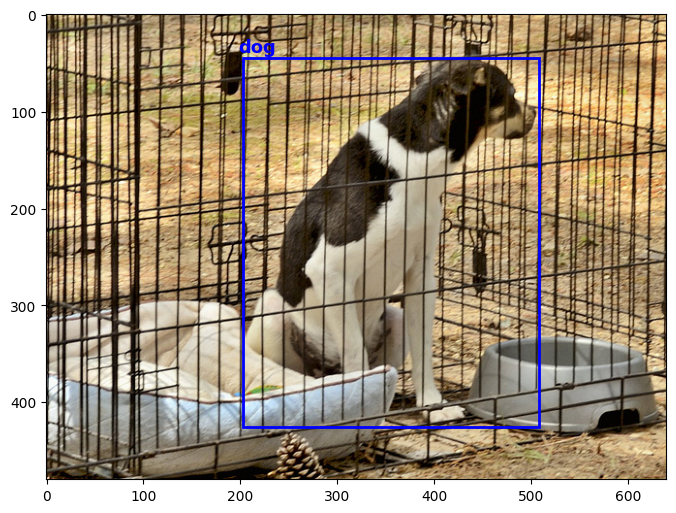

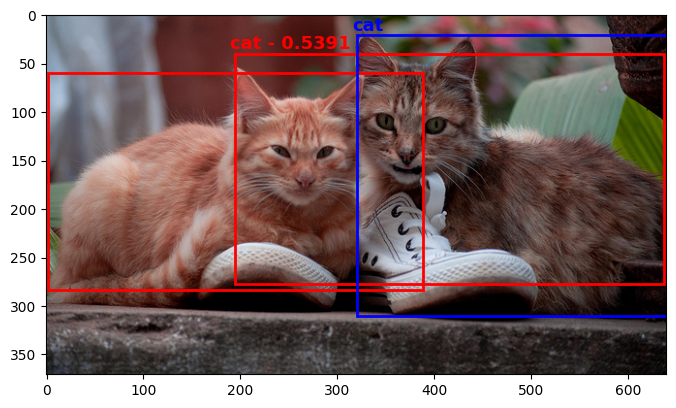

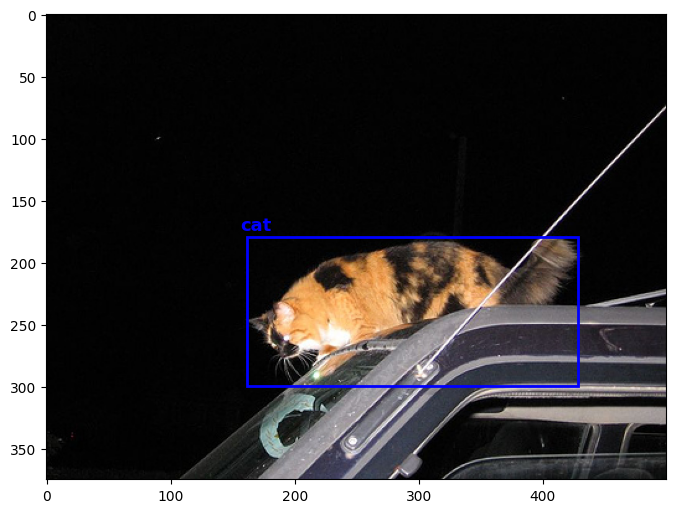

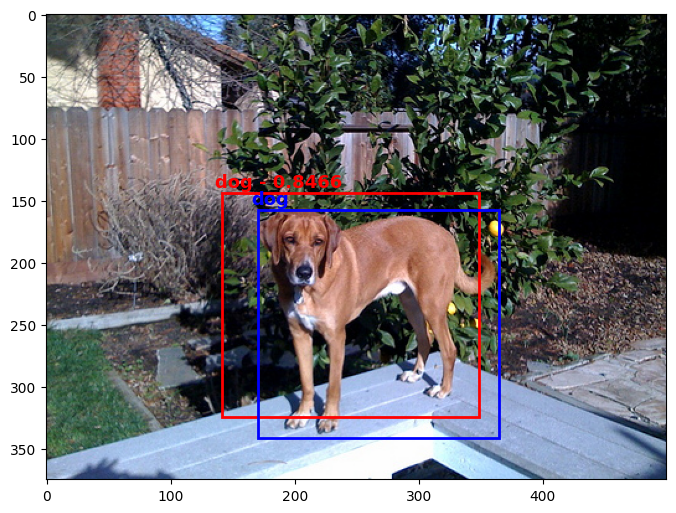

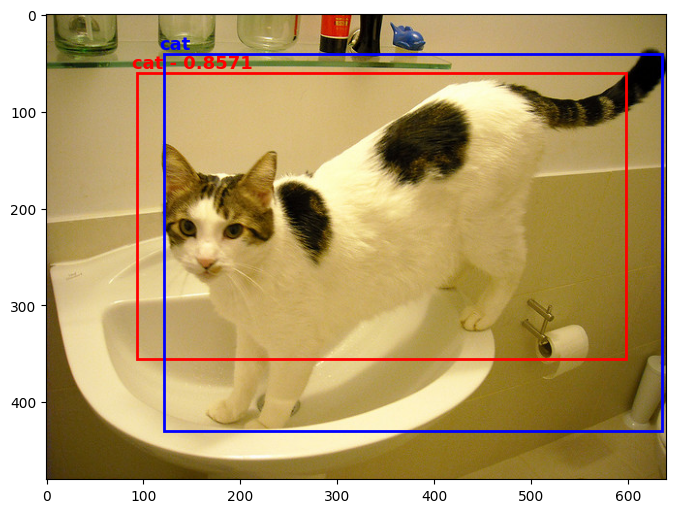

In [ ]:
### 테스트 및 시각화 관련 코드 ###

import numpy as np
from matplotlib import pyplot as plt
from torchvision.transforms.functional import to_pil_image

# 바운딩 박스를 그림으로 표시하는 함수
def draw_bbox(ax, box, text, color):
    """
    바운딩 박스를 이미지에 그려주는 함수.
    :param ax: matplotlib Axes 객체
    :param box: 바운딩 박스 좌표 (x_min, y_min, x_max, y_max)
    :param text: 바운딩 박스 위에 표시할 텍스트
    :param color: 바운딩 박스와 텍스트의 색상
    """
    ax.add_patch(
        plt.Rectangle(
            xy=(box[0], box[1]),
            width=box[2] - box[0],
            height=box[3] - box[1],
            fill=False,
            edgecolor=color,
            linewidth=2,
        )
    )
    ax.annotate(
        text=text,
        xy=(box[0] - 5, box[1] - 5),
        color=color,
        weight="bold",
        fontsize=13,
    )

num_vis = 0
threshold = 0.5  # 예측 점수 임계값: 이 값 이상인 예측만 시각화에 사용
categories = test_dataset.categories  # COCO 데이터셋의 카테고리 정보 사용

with torch.no_grad():  # 평가 시에는 기울기 계산을 하지 않습니다.
    model.eval()       # 모델을 평가 모드로 전환
    for images, targets in test_dataloader:
        images = [image.to(device) for image in images]
        outputs = model(images)  # 모델로부터 예측 결과 생성

        # 예측 결과에서 바운딩 박스, 라벨, 점수를 CPU의 numpy 배열로 변환
        boxes = outputs[0]["boxes"].to("cpu").numpy()
        labels = outputs[0]["labels"].to("cpu").numpy()
        scores = outputs[0]["scores"].to("cpu").numpy()

        # 임계값 이상의 예측만 선택
        boxes = boxes[scores >= threshold].astype(np.int32)
        labels = labels[scores >= threshold]
        scores = scores[scores >= threshold]

        # 시각화를 위한 플롯 설정 (8x8 크기의 그림)
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(1, 1, 1)
        plt.imshow(to_pil_image(images[0]))  # 첫 번째 이미지를 PIL 이미지로 변환하여 출력

        # 예측 결과(빨간색 박스) 시각화
        for box, label, score in zip(boxes, labels, scores):
            draw_bbox(ax, box, f"{categories[label]} - {score:.4f}", "red")

        # 정답 어노테이션(파란색 박스) 시각화
        tboxes = targets[0]["boxes"].numpy()
        tlabels = targets[0]["labels"].numpy()
        for box, label in zip(tboxes, tlabels):
            draw_bbox(ax, box, f"{categories[label]}", "blue")

        plt.show()  # 시각화 결과 출력
        num_vis += 1
        if num_vis == 5:
            break


In [ ]:
### IoU 및 mAP 평가 관련 함수 ###

def compute_iou_numpy(boxes1, boxes2):
    """
    numpy를 사용하여 두 박스 집합 간의 IoU(Intersection over Union)를 계산합니다.
    :param boxes1: (N, 4) 배열, 각 박스는 [x_min, y_min, x_max, y_max] 형태
    :param boxes2: (M, 4) 배열, 각 박스는 [x_min, y_min, x_max, y_max] 형태
    :return: (N, M) IoU 배열
    """
    # 각 박스의 면적 계산
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    # 교집합 좌표 계산
    inter_x1 = np.maximum(boxes1[:, None, 0], boxes2[None, :, 0])
    inter_y1 = np.maximum(boxes1[:, None, 1], boxes2[None, :, 1])
    inter_x2 = np.minimum(boxes1[:, None, 2], boxes2[None, :, 2])
    inter_y2 = np.minimum(boxes1[:, None, 3], boxes2[None, :, 3])

    inter_w = np.maximum(inter_x2 - inter_x1, 0)
    inter_h = np.maximum(inter_y2 - inter_y1, 0)
    inter_area = inter_w * inter_h
    union_area = area1[:, None] + area2 - inter_area
    return inter_area / (union_area + 1e-6)

def voc_ap(recalls, precisions):
    """
    VOC 방식의 AP(Average Precision) 계산 함수.
    :param recalls: 재현율 배열 (오름차순)
    :param precisions: 정밀도 배열 (recalls에 대응하는 값)
    :return: AP 값 (0과 1 사이의 값)
    """
    # 양쪽 끝을 0과 1로 패딩
    mrec = np.concatenate(([0.], recalls, [1.]))
    mpre = np.concatenate(([0.], precisions, [0.]))
    # 정밀도 보정: 뒤에서부터 최대값으로 보정
    for i in range(len(mpre) - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])
    # recall 변화가 있는 지점에서 면적을 합산
    idx = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[idx + 1] - mrec[idx]) * mpre[idx + 1])
    return ap

def evaluate_detections(predictions, ground_truths, iou_threshold=0.5, num_classes=3):
    """
    예측 결과와 Ground Truth를 바탕으로 클래스별 AP와 전체 mAP를 계산합니다.
    :param predictions: 각 예측 인스턴스를 담은 리스트 (dict 형식)
           예: { "image_id": int, "bbox": [x, y, w, h], "score": float, "label": int }
    :param ground_truths: 전체 Ground Truth를 담은 리스트 (dict 형식)
           예: { "image_id": int, "boxes": numpy array of shape (N,4), "labels": numpy array of shape (N,) }
    :param iou_threshold: IoU 임계값 (기본 0.5)
    :param num_classes: 전체 클래스 수 (배경 포함)
    :return: 전체 mAP (mean Average Precision)
    """
    aps = []
    # 배경(0)은 평가에서 제외하고 강아지(1), 고양이(2)만 평가합니다.
    for cls in range(1, num_classes):
        # 해당 클래스의 예측 결과를 점수 내림차순으로 정렬
        cls_preds = [p for p in predictions if p["label"] == cls]
        cls_preds = sorted(cls_preds, key=lambda p: p["score"], reverse=True)

        # 각 이미지별로 해당 클래스의 Ground Truth 박스를 모음
        gt_by_image = {}
        for gt in ground_truths:
            inds = np.where(gt["labels"] == cls)[0]
            boxes = gt["boxes"][inds] if len(inds) > 0 else np.array([]).reshape(0, 4)
            gt_by_image[gt["image_id"]] = {"boxes": boxes, "detected": np.zeros(len(boxes), dtype=bool)}

        num_gt = sum([len(v["boxes"]) for v in gt_by_image.values()])
        if num_gt == 0:
            continue

        tp = np.zeros(len(cls_preds))
        fp = np.zeros(len(cls_preds))
        for i, pred in enumerate(cls_preds):
            image_id = pred["image_id"]
            pred_box = np.array(pred["bbox"])  # [x, y, w, h]
            # [x, y, w, h] -> [x_min, y_min, x_max, y_max] 변환
            pred_box_xyxy = np.array([pred_box[0], pred_box[1], pred_box[0] + pred_box[2], pred_box[1] + pred_box[3]])
            if image_id in gt_by_image:
                gt_boxes = gt_by_image[image_id]["boxes"]
                if gt_boxes.shape[0] == 0:
                    fp[i] = 1
                else:
                    ious = compute_iou_numpy(np.expand_dims(pred_box_xyxy, axis=0), gt_boxes)
                    max_iou = np.max(ious) if ious.size > 0 else 0
                    max_ind = np.argmax(ious) if ious.size > 0 else -1
                    if max_iou >= iou_threshold:
                        # 아직 매칭되지 않은 Ground Truth이면 true positive 처리
                        if not gt_by_image[image_id]["detected"][max_ind]:
                            tp[i] = 1
                            gt_by_image[image_id]["detected"][max_ind] = True
                        else:
                            fp[i] = 1
                    else:
                        fp[i] = 1
            else:
                fp[i] = 1

        # 누적 true positive, false positive 계산
        cum_tp = np.cumsum(tp)
        cum_fp = np.cumsum(fp)
        recalls = cum_tp / (num_gt + 1e-6)
        precisions = cum_tp / (cum_tp + cum_fp + 1e-6)
        ap = voc_ap(recalls, precisions)
        print(f"클래스 {cls} AP: {ap:.3f}")
        aps.append(ap)

    mAP = np.mean(aps) if aps else 0.0
    print(f"전체 mAP: {mAP:.3f}")
    return mAP


`compute_iou_numpy()` 함수는 **객체 탐지(Object Detection)**에서 **예측 박스와 정답 박스 간의 일치 정도(IoU, Intersection over Union)**를 정량적으로 평가하는 **핵심 함수**입니다. 이 함수는 **모델 학습, 성능 평가(mAP 등), NMS(비최대 억제)** 등에 필수로 사용됩니다.

---

## ✅ 먼저: IoU란?

- *IoU (Intersection over Union)**는 두 사각형(예측 박스 vs 정답 박스)이 얼마나 겹치는지를 나타내는 지표입니다.

### 수식 정의

$$
IoU = \frac{\text{교집합 면적}}{\text{합집합 면적}} \in [0, 1]
$$


- 1: 완전히 일치
- 0: 전혀 겹치지 않음

---

## 🔍 `compute_iou_numpy()` 상세 분석

```python
python
복사편집
def compute_iou_numpy(boxes1, boxes2):

```

- `boxes1`: (N, 4) numpy array → N개의 예측 박스
- `boxes2`: (M, 4) numpy array → M개의 Ground Truth 박스
    
    → 최종적으로 `(N, M)` 형태의 IoU 행렬 반환
    

---

### ▶️ Step-by-step 해설

### ✅ 1. 면적 계산

```python
python
복사편집
area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])  # N,
area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])  # M,

```

- `[x_min, y_min, x_max, y_max]` → `width * height`
- 각 박스의 **면적**을 구함

---

### ✅ 2. 교집합 영역 좌표 구하기

```python
python
복사편집
inter_x1 = np.maximum(boxes1[:, None, 0], boxes2[None, :, 0])
inter_y1 = np.maximum(boxes1[:, None, 1], boxes2[None, :, 1])
inter_x2 = np.minimum(boxes1[:, None, 2], boxes2[None, :, 2])
inter_y2 = np.minimum(boxes1[:, None, 3], boxes2[None, :, 3])

```

- `boxes1[:, None, :]`: (N, 1, 4)로 변형 → 브로드캐스팅 용이
- `boxes2[None, :, :]`: (1, M, 4)
- → 결과적으로 모든 (box1, box2) 쌍마다 **교차 영역 좌상단/우하단 좌표**를 계산

---

### ✅ 3. 교집합 넓이 계산

```python
python
복사편집
inter_w = np.maximum(inter_x2 - inter_x1, 0)
inter_h = np.maximum(inter_y2 - inter_y1, 0)
inter_area = inter_w * inter_h

```

- 교차 너비와 높이가 **음수이면 겹치지 않으므로 0 처리**
- `inter_area`: shape = (N, M)

---

### ✅ 4. 합집합 넓이 및 IoU 계산

```python
python
복사편집
union_area = area1[:, None] + area2 - inter_area
return inter_area / (union_area + 1e-6)

```

- IoU = 교집합 / 합집합
- `+1e-6`: 0 나누기 방지 (수치 안정성)

---

## 📊 예시

```python
python
복사편집
boxes1 = np.array([
    [0, 0, 100, 100],   # 예측 박스
])

boxes2 = np.array([
    [50, 50, 150, 150], # 정답 박스
    [0, 0, 100, 100]    # 완전 일치
])

compute_iou_numpy(boxes1, boxes2)
→ array([[0.142857, 1.0]])

```

- 첫 번째 박스는 일부 겹침
- 두 번째 박스는 완전 겹침 → IoU = 1.0

---

## 📌 이 함수가 중요한 이유

| 사용처 | 설명 |
| --- | --- |
| 🎯 학습 데이터 정답 매칭 | Anchor가 GT와 충분히 겹치면 Positive Sample로 간주 |
| ✅ 평가 (mAP) | 예측이 GT와 얼마나 일치하는지 판단 |
| ❌ NMS | IoU가 높은 박스들을 억제하여 중복 제거 |

---

## 💡 팁

- Pytorch 버전이 필요하면 `torchvision.ops.box_iou()` 사용 가능
- 이 함수는 2D 좌표 박스에만 적용됨 (3D 박스는 별도 처리)
- 다양한 IoU 변형(ex. GIoU, DIoU, CIoU)도 유사한 구조로 계산 가능

In [ ]:
# Ground Truth와 예측 결과 준비

# test_dataset.data는 (image, target) 튜플의 리스트이며,
# target에는 "image_id", "boxes", "labels"가 tensor 형태로 저장되어 있습니다.
ground_truths = []
for _, target in test_dataset.data:
    gt = {
        "image_id": int(target["image_id"].item()),
        "boxes": target["boxes"].numpy(),  # [x_min, y_min, x_max, y_max]
        "labels": target["labels"].numpy()
    }
    ground_truths.append(gt)

# 예측 결과 생성 (각 예측은 dict 형식으로 저장)
# 예: { "image_id": int, "bbox": [x, y, w, h], "score": float, "label": int }
predictions = []
with torch.no_grad():
    model.eval()
    for images, targets in test_dataloader:
        images = [img.to(device) for img in images]
        outputs = model(images)
        for i in range(len(targets)):
            image_id = int(targets[i]["image_id"].item())
            # 예측된 박스는 [x_min, y_min, x_max, y_max] 형태입니다.
            boxes = outputs[i]["boxes"].data.cpu().numpy()
            scores = outputs[i]["scores"].data.cpu().numpy()
            labels = outputs[i]["labels"].data.cpu().numpy()
            for j in range(len(boxes)):
                box = boxes[j]
                # [x_min, y_min, x_max, y_max] -> [x, y, w, h]로 변환 (w = x_max - x_min, h = y_max - y_min)
                bbox = [box[0], box[1], box[2] - box[0], box[3] - box[1]]
                predictions.append({
                    "image_id": image_id,
                    "bbox": bbox,
                    "score": float(scores[j]),
                    "label": int(labels[j])
                })

# 평가 실행: 강아지, 고양이(배경은 제외한 1, 2번 클래스)의 AP와 전체 mAP 계산
evaluate_detections(predictions, ground_truths, iou_threshold=0.5, num_classes=3)

클래스 1 AP: 0.641
클래스 2 AP: 0.604
전체 mAP: 0.623


np.float64(0.6226361780052165)

### 모델링(Pycocotools 활용)

- MS COCO 데이터 측에서 제공하는 관련 툴 : https://github.com/cocodataset/cocoapi/tree/master/PythonAPI

In [ ]:
# # 먼저, 압축 파일(pytorch-transformer.zip)을 지정된 경로(현재 디렉토리)로 압축 해제합니다.
# import shutil
# shutil.unpack_archive(
#     filename="pytorch-transformer.zip",  # 압축 해제할 파일 경로
#     extract_dir="./",                     # 압축 해제할 디렉토리 (현재 디렉토리)
#     format="zip"                          # 압축 파일 형식 지정
# )


In [ ]:
# 작업 디렉토리를 변경합니다.
import os
os.chdir("/content/4/datasets/")  # 작업할 데이터셋 폴더로 이동 (실행 환경에 따라 경로가 달라질 수 있음)

In [ ]:
# 필요한 라이브러리들을 임포트합니다.
import torch
from PIL import Image                   # 이미지 처리를 위한 Pillow 라이브러리
from pycocotools.coco import COCO         # COCO 데이터셋을 다루기 위한 라이브러리
from torch.utils.data import Dataset      # PyTorch의 Dataset 클래스를 상속받기 위해 사용


# COCO 데이터셋을 처리하기 위한 사용자 정의 Dataset 클래스
class COCODataset(Dataset):
    def __init__(self, root, train, transform=None):
        """
        초기화 함수:
        - root: 데이터셋의 최상위 경로
        - train: 학습용 데이터(True)와 검증용 데이터(False) 구분
        - transform: 이미지 전처리를 위한 변환 함수 (예: tensor 변환)
        """
        super().__init__()
        # 'train'이 True면 'train' 디렉토리, 아니면 'val' 디렉토리를 사용합니다.
        directory = "train" if train else "val"
        # 해당 디렉토리의 주석(annotation) 파일 경로를 설정합니다.
        annotations = os.path.join(root, "annotations", f"{directory}_annotations.json")

        # COCO 형식의 주석 데이터를 불러옵니다.
        self.coco = COCO(annotations)
        # 이미지가 저장된 경로 설정 (train 또는 val 디렉토리)
        self.image_path = os.path.join(root, directory)
        # 이미지 전처리 변환 함수 저장
        self.transform = transform

        # 데이터셋 내 모든 카테고리 정보를 가져옵니다.
        self.categories = self._get_categories()
        # 이미지와 그에 해당하는 어노테이션을 로드합니다.
        self.data = self._load_data()

    def _get_categories(self):
        """
        COCO 데이터셋 내 카테고리 정보를 딕셔너리 형태로 반환합니다.
        0번 인덱스는 배경("background")으로 초기화합니다.
        """
        categories = {0: "background"}
        for category in self.coco.cats.values():
            categories[category["id"]] = category["name"]
        return categories

    def _load_data(self):
        """
        COCO 데이터셋의 각 이미지에 대해:
        - 이미지를 로드하고,
        - 해당 이미지의 어노테이션(바운딩 박스와 라벨)을 추출하여 target으로 구성합니다.
        그리고 (이미지, target) 튜플의 리스트로 반환합니다.
        """
        data = []
        for _id in self.coco.imgs:
            # 이미지 정보를 불러오고 파일 이름을 추출합니다.
            file_name = self.coco.loadImgs(_id)[0]["file_name"]
            # 파일 경로 생성
            image_path = os.path.join(self.image_path, file_name)
            # 이미지를 RGB 모드로 열기
            image = Image.open(image_path).convert("RGB")

            boxes = []   # 바운딩 박스 좌표를 저장할 리스트
            labels = []  # 해당 박스의 카테고리 id 저장할 리스트
            # 이미지에 해당하는 모든 어노테이션 정보를 불러옵니다.
            anns = self.coco.loadAnns(self.coco.getAnnIds(_id))
            for ann in anns:
                # 어노테이션에서 x, y 좌표와 width, height를 가져옵니다.
                x, y, w, h = ann["bbox"]
                # 좌표 정보를 [x_min, y_min, x_max, y_max] 형태로 변환하여 저장
                #  (Faster RCNN은 x_min, y_min, x_max, y_max 형태 사용)
                boxes.append([x, y, x + w, y + h])
                # 라벨 정보(카테고리 id)를 저장
                labels.append(ann["category_id"])

            # target 딕셔너리에 이미지 id, 바운딩 박스, 라벨 정보를 tensor로 변환하여 저장
            target = {
                "image_id": torch.LongTensor([_id]),
                "boxes": torch.FloatTensor(boxes),
                "labels": torch.LongTensor(labels)
            }
            # 이미지와 target 정보를 튜플 형태로 저장
            data.append([image, target])
        return data

    def __getitem__(self, index):
        """
        Dataset의 특정 index에 해당하는 (이미지, target) 튜플을 반환합니다.
        만약 transform이 있다면 이미지에 적용합니다.
        """
        image, target = self.data[index]
        if self.transform:
            image = self.transform(image)
        return image, target

    def __len__(self):
        """
        데이터셋의 전체 샘플 개수를 반환합니다.
        """
        return len(self.data)

In [ ]:
# torchvision 라이브러리에서 이미지 전처리 도구와 DataLoader를 임포트합니다.
from torchvision import transforms
from torch.utils.data import DataLoader

# 배치 데이터를 생성할 때, 각 배치마다 데이터를 튜플 형태로 묶어주는 함수
# coco 데이터 셋은 이미지 내에 여러 객체 정보가 담길 수 있으므로, 데이터의 길이가 다를 수 있음.
def collator(batch):
    return tuple(zip(*batch))

# 이미지 전처리: PIL 이미지를 텐서로 변환하고, 데이터 타입을 float으로 변환
transform = transforms.Compose(
    [
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(dtype=torch.float)
    ]
)

# 학습 데이터와 테스트(검증) 데이터를 위한 COCO 데이터셋 객체 생성
train_dataset = COCODataset("./coco", train=True, transform=transform)
test_dataset = COCODataset("./coco", train=False, transform=transform)

# DataLoader를 사용하여 데이터셋을 배치 단위로 불러옵니다.
train_dataloader = DataLoader(
    train_dataset, batch_size=4, shuffle=True, drop_last=True, collate_fn=collator
)
test_dataloader = DataLoader(
    test_dataset, batch_size=1, shuffle=True, drop_last=True, collate_fn=collator
)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
# torchvision 라이브러리에서 사전 학습된 모델과 관련 모듈을 임포트합니다.
from torchvision import models
from torchvision import ops
from torchvision.models.detection import rpn
from torchvision.models.detection import FasterRCNN

# 사전 학습된 VGG16 모델의 feature extractor(특징 추출기)를 backbone으로 사용합니다.
backbone = models.vgg16(weights="VGG16_Weights.IMAGENET1K_V1").features
backbone.out_channels = 512  # backbone의 출력 채널 수 설정

# RPN(Region Proposal Network)에서 사용할 앵커 생성기 설정
anchor_generator = rpn.AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),       # 각 스케일별 앵커 크기 지정
    aspect_ratios=((0.5, 1.0, 2.0),)         # 각 앵커의 가로 세로 비율 지정
)

# ROI Pooling: 여러 스케일의 특징맵에서 RoI(Region of Interest)를 고정 크기로 변환
roi_pooler = ops.MultiScaleRoIAlign(
    featmap_names=["0"],         # 사용할 특징맵 이름
    output_size=(7, 7),          # 출력 크기 설정 (7x7)
    sampling_ratio=2             # 샘플링 비율 지정
)

# 학습에 사용할 디바이스를 설정 (GPU가 있으면 cuda, 없으면 cpu)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Faster R-CNN 모델을 생성합니다.
# - backbone: 특징 추출기 (VGG16 사용)
# - num_classes: 검출할 클래스 수 (배경 포함; 여기서는 3개로 설정)
# - rpn_anchor_generator: 위에서 설정한 앵커 생성기
# - box_roi_pool: 위에서 설정한 ROI 풀링 모듈
model = FasterRCNN(
    backbone=backbone,
    num_classes=3,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
).to(device)  # 모델을 선택한 디바이스로 이동


In [ ]:
# 모델 학습을 위한 최적화 기법 설정 (SGD 사용)
from torch import optim
params = [p for p in model.parameters() if p.requires_grad]  # 학습 가능한 파라미터들만 선택
optimizer = optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
# 학습률 스케줄러: 일정 에폭마다 학습률 감소
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
from tqdm import tqdm

# 학습 루프 (5 에폭 동안 학습)
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    # tqdm 진행바를 사용하여 학습 진행 표시
    train_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")
    for images, targets in train_bar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()
        train_bar.set_postfix(loss=f"{losses.item():.3f}")

    lr_scheduler.step()
    avg_train_loss = total_loss / len(train_dataloader)


    print(f"Epoch: {epoch+1:2d}, Avg Train Loss: {avg_train_loss:.3f}")

    # 사용하지 않는 GPU 메모리 해제
    torch.cuda.empty_cache()


Epoch 1/5 - Training: 100%|██████████| 607/607 [07:58<00:00,  1.27it/s, loss=0.337]


Epoch:  1, Avg Train Loss: 0.449


Epoch 2/5 - Training: 100%|██████████| 607/607 [08:00<00:00,  1.26it/s, loss=0.330]


Epoch:  2, Avg Train Loss: 0.300


Epoch 3/5 - Training: 100%|██████████| 607/607 [08:01<00:00,  1.26it/s, loss=0.357]


Epoch:  3, Avg Train Loss: 0.275


Epoch 4/5 - Training: 100%|██████████| 607/607 [07:58<00:00,  1.27it/s, loss=0.142]


Epoch:  4, Avg Train Loss: 0.263


Epoch 5/5 - Training: 100%|██████████| 607/607 [08:01<00:00,  1.26it/s, loss=0.207]

Epoch:  5, Avg Train Loss: 0.253


In [ ]:
# 테스트 이미지에 대한 예측 결과를 시각화하기 위한 라이브러리 임포트
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from torchvision.transforms.functional import to_pil_image

# 바운딩 박스를 그림으로 표시하는 함수 정의
def draw_bbox(ax, box, text, color):
    """
    - ax: matplotlib Axes 객체
    - box: 바운딩 박스 좌표 (x_min, y_min, x_max, y_max)
    - text: 바운딩 박스 위에 표시할 텍스트
    - color: 바운딩 박스와 텍스트의 색상
    """
    ax.add_patch(
        plt.Rectangle(
            xy=(box[0], box[1]),
            width=box[2] - box[0],
            height=box[3] - box[1],
            fill=False,
            edgecolor=color,
            linewidth=2,
        )
    )
    ax.annotate(
        text=text,
        xy=(box[0] - 5, box[1] - 5),
        color=color,
        weight="bold",
        fontsize=13,
    )

# 임계값(threshold) 설정: 예측 점수가 이 값 이상일 때만 결과를 사용
threshold = 0.5
categories = test_dataset.categories  # 테스트 데이터셋의 카테고리 정보를 사용
with torch.no_grad():  # 평가 시에는 기울기 계산을 하지 않음
    model.eval()       # 모델을 평가 모드로 전환
    # 테스트 데이터셋의 배치 단위로 반복
    for images, targets in test_dataloader:
        # 이미지를 디바이스로 이동
        images = [image.to(device) for image in images]
        # 모델을 통해 예측 수행
        outputs = model(images)

        # 예측 결과에서 바운딩 박스, 라벨, 점수를 CPU의 numpy 배열로 변환
        boxes = outputs[0]["boxes"].to("cpu").numpy()
        labels = outputs[0]["labels"].to("cpu").numpy()
        scores = outputs[0]["scores"].to("cpu").numpy()

        # 점수가 threshold 이상인 예측만 선택
        boxes = boxes[scores >= threshold].astype(np.int32)
        labels = labels[scores >= threshold]
        scores = scores[scores >= threshold]

        # 시각화를 위한 플롯 설정 (그림 크기 8x8)
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(1, 1, 1)
        plt.imshow(to_pil_image(images[0]))  # 첫 번째 이미지를 PIL 이미지로 변환 후 출력

        # 예측 결과(빨간색 박스) 시각화
        for box, label, score in zip(boxes, labels, scores):
            draw_bbox(ax, box, f"{categories[label]} - {score:.4f}", "red")

        # 정답 어노테이션(파란색 박스) 시각화
        tboxes = targets[0]["boxes"].numpy()
        tlabels = targets[0]["labels"].numpy()
        for box, label in zip(tboxes, tlabels):
            draw_bbox(ax, box, f"{categories[label]}", "blue")

        plt.show()  # 시각화 결과 출력

In [ ]:
# COCO 평가 도구를 사용하여 모델의 성능을 평가합니다.
import numpy as np
from pycocotools.cocoeval import COCOeval

with torch.no_grad():
    model.eval()
    coco_detections = []  # COCO 형식의 예측 결과를 저장할 리스트
    # 테스트 데이터셋 배치 단위 반복
    for images, targets in test_dataloader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        for i in range(len(targets)):
            # 이미지 id 추출 (COCO 형식은 이미지 id가 필요)
            image_id = targets[i]["image_id"].data.cpu().numpy().tolist()[0]
            # 예측한 바운딩 박스 추출 (좌표 값)
            boxes = outputs[i]["boxes"].data.cpu().numpy()
            # COCO 평가 형식에 맞게 [x, y, width, height] 형태로 변환
            boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
            scores = outputs[i]["scores"].data.cpu().numpy()
            labels = outputs[i]["labels"].data.cpu().numpy()

            # 각 예측 인스턴스에 대해 COCO 평가용 배열 생성
            for instance_id in range(len(boxes)):
                box = boxes[instance_id, :].tolist()
                prediction = np.array(
                    [
                        image_id,                # 이미지 id
                        box[0],                  # x 좌표
                        box[1],                  # y 좌표
                        box[2],                  # width (x_max - x_min)
                        box[3],                  # height (y_max - y_min)
                        float(scores[instance_id]),  # 예측 점수
                        int(labels[instance_id]),      # 예측 라벨
                    ]
                )
                coco_detections.append(prediction)

    coco_detections = np.asarray(coco_detections)  # 리스트를 numpy 배열로 변환
    coco_gt = test_dataloader.dataset.coco        # COCO 형식의 ground truth 어노테이션 로드
    coco_dt = coco_gt.loadRes(coco_detections)      # 예측 결과를 COCO 형식으로 변환
    coco_evaluator = COCOeval(coco_gt, coco_dt, iouType="bbox")  # 평가 도구 초기화 (bbox 기준)
    coco_evaluator.evaluate()   # 각 이미지별 평가 수행
    coco_evaluator.accumulate() # 결과 누적
    coco_evaluator.summarize()  # 평가 결과 요약 및 출력


Loading and preparing results...
Converting ndarray to lists...
(1572, 7)
0/1572
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.261
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.588
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.194
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.067
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.275
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.303
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.334
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.462
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.464
 Average Recall     

# 실습(Pascal VOC 2007)

In [ ]:
# VOC2007 train/val 데이터셋 다운로드 (예: VOCtrainval_06-Nov-2007.tar)
!wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar

# 압축 해제 (VOCdevkit/VOC2007 폴더가 생성됨)
!tar -xvf VOCtrainval_06-Nov-2007.tar

In [ ]:
import os
import xml.etree.ElementTree as ET
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms, models, ops
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection import rpn
from torch import optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.functional import to_pil_image
from tqdm import tqdm

# VOC 클래스 목록 (첫번째 __background__ 포함)
VOC_CLASSES = (
    "__background__",
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
)
# 클래스 이름을 id로 매핑하는 딕셔너리 생성 (ex: 'cat': 9)
VOC_CLASS_TO_ID = {cls: idx for idx, cls in enumerate(VOC_CLASSES)}

class VOCDataset(Dataset):
    def __init__(self, root, image_set="train", transform=None):
        """
        Args:
            root (str): VOC 데이터셋의 루트 경로 (예: "VOCdevkit/VOC2007")
            image_set (str): 사용할 이미지 세트("train", "val" 또는 "test")
            transform: 이미지 전처리(transform)를 위한 torchvision.transforms 객체
        """
        self.root = root
        self.image_set = image_set
        self.transform = transform

        # VOC 데이터셋은 보통 ImageSets/Main 폴더에 train.txt, val.txt 등이 있음.
        # 해당 파일이 존재하면 그 파일의 id 목록을 사용하고, 없으면 JPEGImages 폴더의 모든 파일을 사용합니다.
        imageset_file = os.path.join(root, "ImageSets", "Main", f"{image_set}.txt")
        if os.path.exists(imageset_file):
            with open(imageset_file, "r") as f:
                self.ids = [line.strip() for line in f.readlines()]
        else:
            # 파일명이 확장자를 제외한 이름으로 id로 사용
            jpeg_folder = os.path.join(root, "JPEGImages")
            self.ids = [os.path.splitext(f)[0] for f in os.listdir(jpeg_folder) if f.endswith(".jpg")]

        self.jpeg_folder = os.path.join(root, "JPEGImages")
        self.ann_folder = os.path.join(root, "Annotations")

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        """
        이미지와 해당 어노테이션(target)을 반환합니다.
        target은 다음의 key를 포함하는 딕셔너리입니다.
            - image_id: 이미지 id (tensor)
            - boxes: 바운딩 박스 좌표 [xmin, ymin, xmax, ymax] (FloatTensor)
            - labels: 클래스 id (LongTensor)
        """
        img_id = self.ids[index]
        # 이미지 파일 경로
        img_path = os.path.join(self.jpeg_folder, f"{img_id}.jpg")
        image = Image.open(img_path).convert("RGB")

        # 어노테이션 XML 파일 경로
        ann_path = os.path.join(self.ann_folder, f"{img_id}.xml")
        boxes = []
        labels = []

        # XML 파싱
        tree = ET.parse(ann_path)
        root_xml = tree.getroot()
        # VOC XML 형식에서 object 태그 아래 정보를 읽음
        for obj in root_xml.findall("object"):
            # difficult 속성이 있으면 고려할 수 있음 (여기서는 모두 사용)
            # difficult = int(obj.find("difficult").text)
            name = obj.find("name").text.lower().strip()
            # VOC 클래스 목록에 없는 클래스라면 건너뜀
            if name not in VOC_CLASS_TO_ID:
                continue
            label = VOC_CLASS_TO_ID[name]
            bndbox = obj.find("bndbox")
            xmin = float(bndbox.find("xmin").text)
            ymin = float(bndbox.find("ymin").text)
            xmax = float(bndbox.find("xmax").text)
            ymax = float(bndbox.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        # target 딕셔너리 구성 (이미지 id는 index 사용)
        target = {
            "image_id": torch.tensor([index]),
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)
        }

        if self.transform:
            image = self.transform(image)

        return image, target
